In [1]:
from funcs import *
from tqdm import tqdm
import matplotlib

In [2]:
world_pop = gpd.read_file('./data/pop.geo.json')
world_pop['POP2005']=world_pop['POP2005'].astype(float)
world_pop['area']=  world_pop.to_crs(6933).area.astype(float)*0.000001
world_pop['density'] = (world_pop['POP2005'].div(world_pop['area']))

In [3]:
country_name_index = {}
for i in range(len(world_pop)):
    row_i = world_pop.iloc[i]
    country_name_index.update({row_i['NAME']:i})

In [4]:
polygons_ = get_polygons(world_pop['geometry'])
source_polygons = get_source_polygons(world_pop['geometry'])
N_vec_ = world_pop['POP2005'].values
Names_ = world_pop['NAME'].values
Areas_ = world_pop['area'].values

In [5]:
hx = 10.0
hy = 10.0

In [6]:
bounds_ = bounds_by_polygons(polygons_)
xgrid,ygrid = make_grids(hx,hy,bounds_)

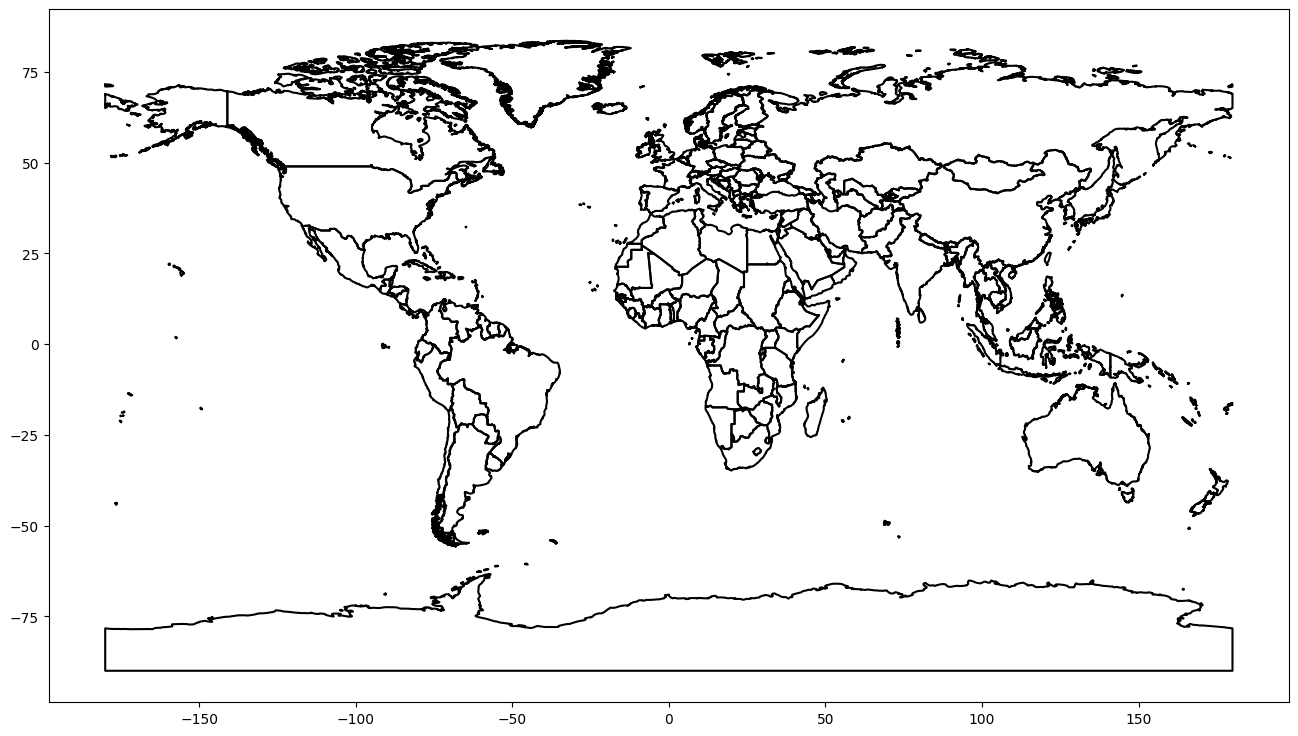

In [7]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
for i in range(len(polygons_ )):
    ax.plot(polygons_[i][0],polygons_[i][1],c='k')

In [8]:
masks_per_state = get_binary_mask_per_state_cv2(source_polygons,
                                xgrid, ygrid)
mask_of_earth = CUPmasks(masks_per_state)
mask_of_water = np.logical_not(mask_of_earth)

100%|██████████| 211/211 [00:00<00:00, 1465.28it/s]


In [9]:
masks_with_N = [masks_per_state[i].astype(np.float64)*N_vec_[i] for i in range(len(masks_per_state))]

In [10]:
mask_of_earth_N = None 
for i in range(len(masks_with_N)):
    if mask_of_earth_N is None:
        mask_of_earth_N = masks_with_N[i]
    else:
        mask_of_earth_N += masks_with_N[i]

In [11]:
cities = pd.read_csv('./data/worldcities.csv')

In [12]:
cities_mask = np.zeros(shape=(len(xgrid),len(ygrid)),dtype=np.float64)
for i in range(len(cities)):
    x = cities.iloc[i]['lng']
    y = cities.iloc[i]['lat']
    z = cities.iloc[i]['population']
    xi = int((x-xgrid[0])/(xgrid[-1]-xgrid[0])*(len(xgrid)-1))
    yi = int((y-ygrid[0])/(ygrid[-1]-ygrid[0])*(len(ygrid)-1))
    if np.isnan(z):
        z = 10**0
    cities_mask[xi][yi] =  z

Text(0.5, 1.0, 'cities')

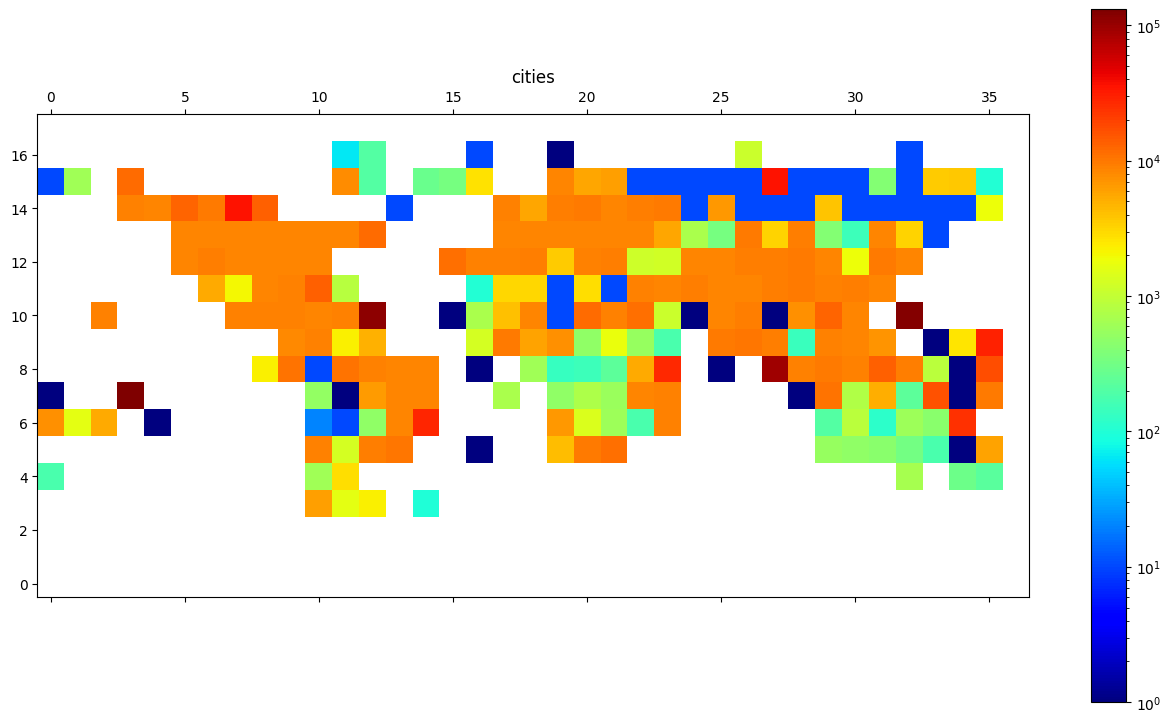

In [13]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(cities_mask.T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
fig.colorbar(cax)
ax.set_title('cities')

Text(0.5, 1.0, 'land')

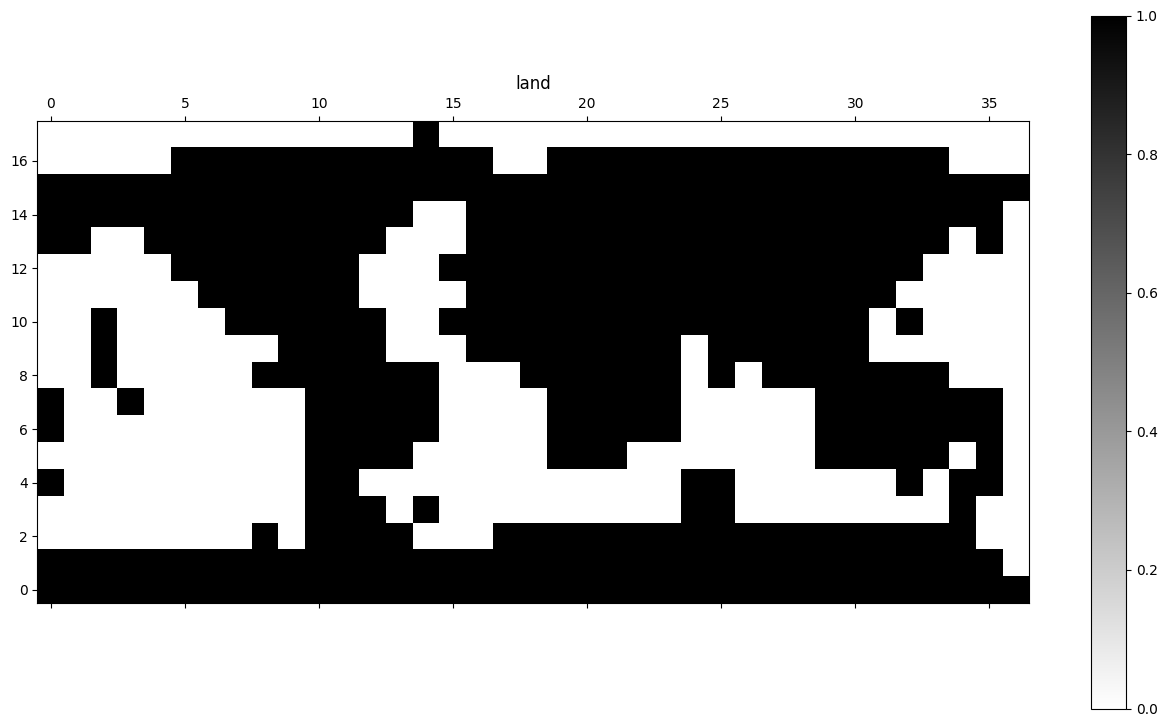

In [14]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(np.asarray(mask_of_earth).T,cmap='binary')
ax.invert_yaxis()
fig.colorbar(cax)
ax.set_title('land')

Text(0.5, 1.0, 'water')

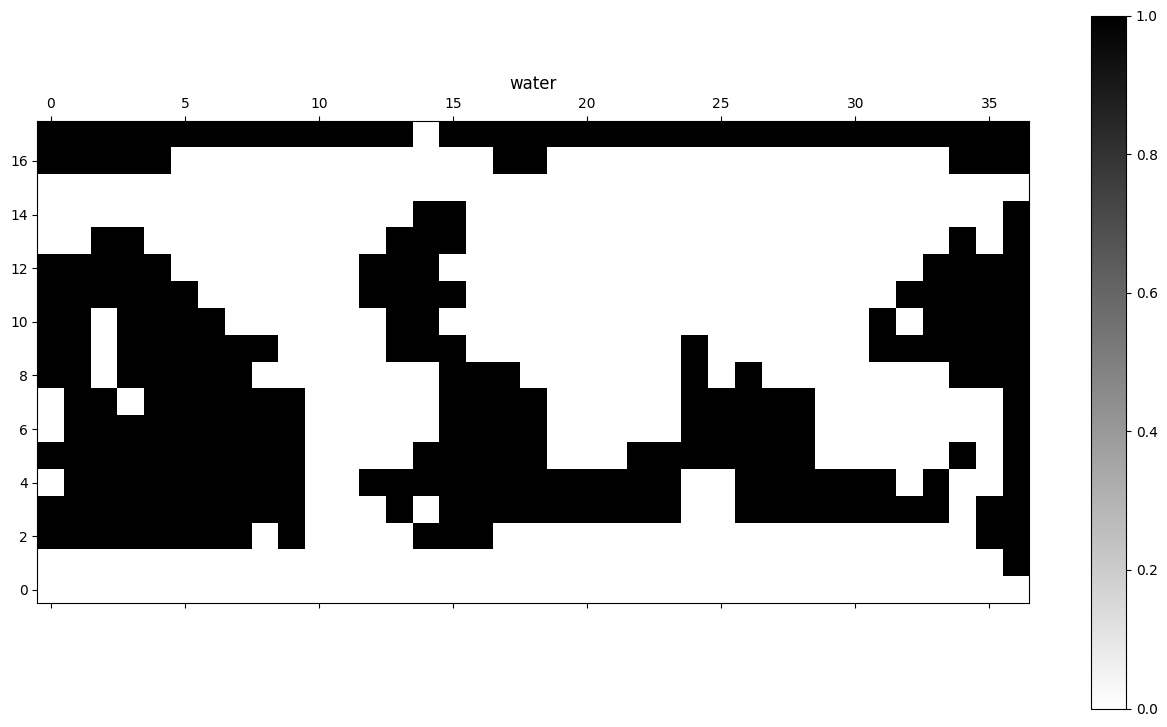

In [15]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(np.asarray(mask_of_water).T,cmap='binary')
ax.invert_yaxis()
fig.colorbar(cax)
ax.set_title('water')

Text(0.5, 1.0, '$2005г.\\ \\sum N_i = 6.163845593, млрд$')

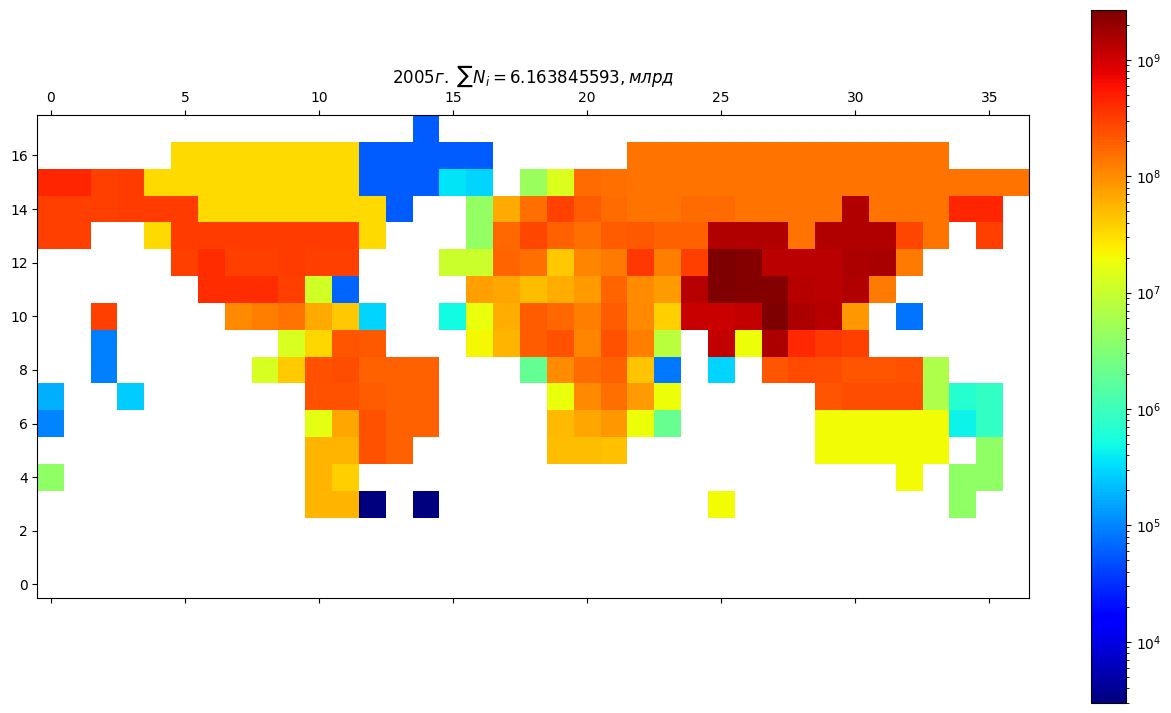

In [16]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(np.asarray(mask_of_earth_N).T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
fig.colorbar(cax)
ax.set_title(r'$2005г.\ \sum N_i = {}, млрд$'.format(np.sum(N_vec_)/10**9))

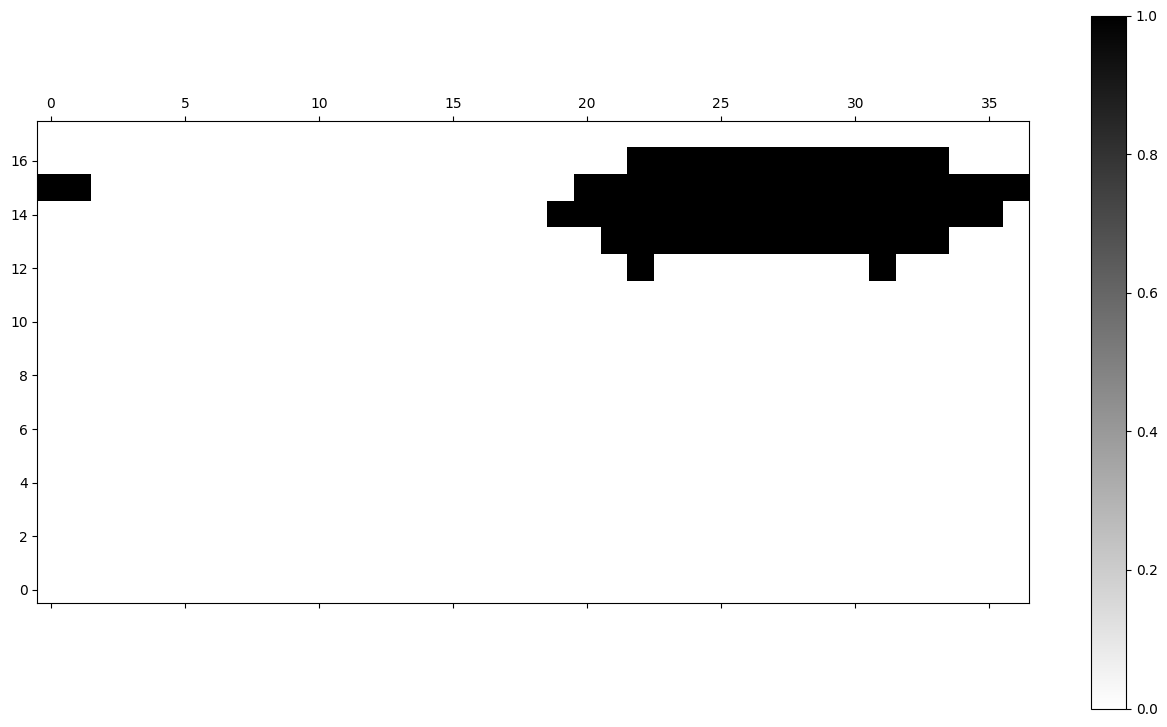

In [17]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(np.asarray(masks_per_state[country_name_index['Russia']]).T,cmap='binary')
ax.invert_yaxis()
fig.colorbar(cax)

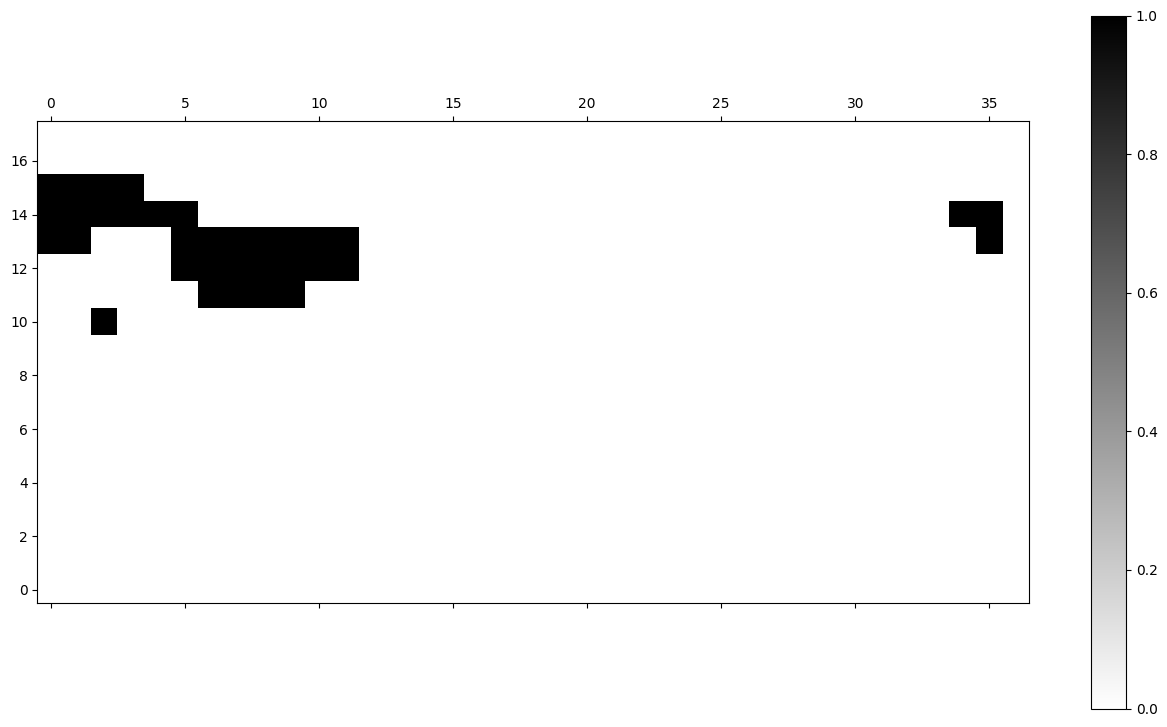

In [18]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(np.asarray(masks_per_state[country_name_index['United States']]).T,cmap='binary')
ax.invert_yaxis()
fig.colorbar(cax)

In [19]:
poly_per_state = get_polygons_per_state(world_pop['geometry'])

In [20]:
c_mask = np.copy(masks_per_state[country_name_index['Russia']])
c_N = N_vec_[country_name_index['Russia']]
c_grid_count = np.sum(c_mask)
c_boundary_conditions_mask = np.logical_not(c_mask).astype(np.float64)
c_polygons = poly_per_state[country_name_index['Russia']]
c_bounds = [bounds_by_polygons(el) for el in c_polygons]
c_cities_vs = cities_mask*c_mask.astype(np.float64)
c_cities_vs_sum = np.sum(c_cities_vs)
c_cities_vs = (np.sign(c_N-c_cities_vs_sum)*(c_N-c_cities_vs_sum)/np.sum(c_cities_vs>0) + c_cities_vs)*(c_cities_vs>0).astype(np.float64)

Text(0.5, 1.0, '$НУ, \\Sigma = 143953091.99999997$')

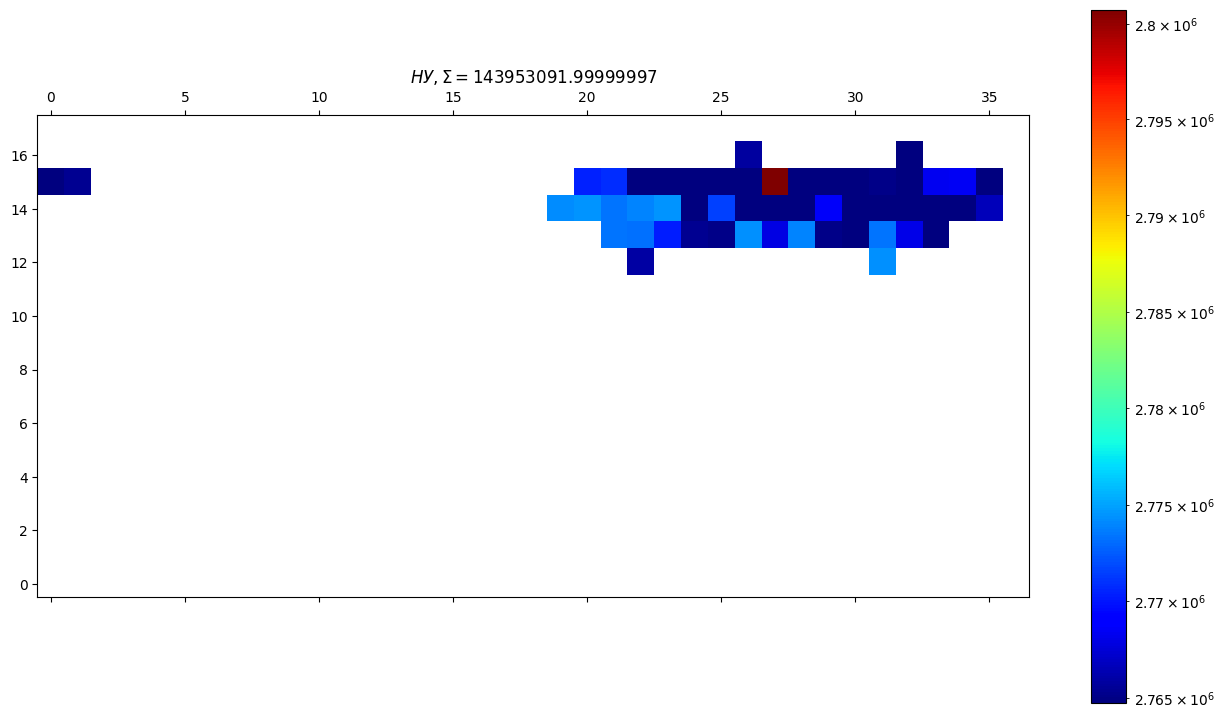

In [21]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(c_cities_vs.T,cmap=matplotlib.cm.jet,norm= matplotlib.colors.LogNorm())
ax.invert_yaxis()
fig.colorbar(cax)
ax.set_title(r'$НУ, \Sigma = {}$'.format(np.sum(c_cities_vs)))

Text(0.5, 1.0, 'ГУ маска')

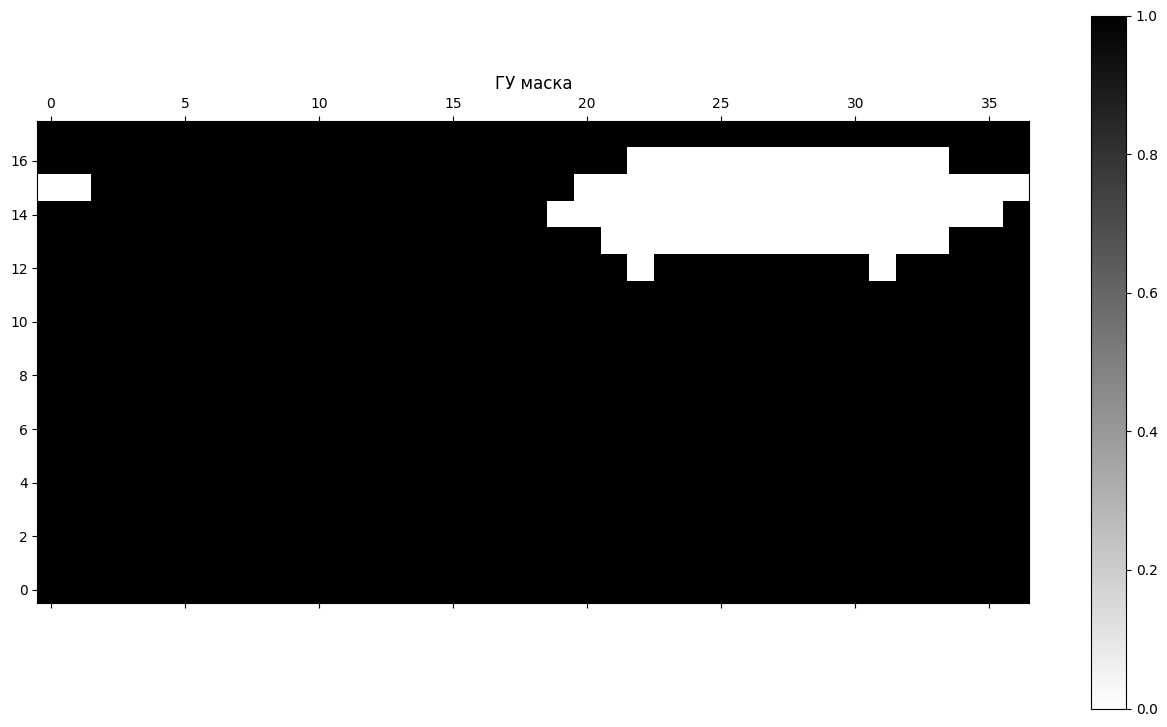

In [22]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(c_boundary_conditions_mask.T,cmap='binary')
ax.invert_yaxis()
fig.colorbar(cax)
ax.set_title('ГУ маска')

In [23]:
@jit(nopython=True)
def D(t,x,y,u):
    return x+y
@jit(nopython=True)
def F(t,x,y,u):
    return 0.0

In [24]:
def solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_,c_boundary_conditions_mask):
    u = np.copy(u_)
    for k in range(Nt-1):
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):
                u_mid = u[k][i][j]
                u_x_right = u[k][i+1][j]
                u_x_left  = u[k][i-1][j]
                u_y_right = u[k][i][j+1]
                u_y_left  = u[k][i][j-1]

                Lx1 = D(t[k],x[i+1],y[j],u_x_right) - D(t[k],x[i],y[j],u_mid)
                Lx1 *= u_x_right - u_mid
                Lx1 *= 1.0/(hx**2)  
                Lx2 = D(t[k],x[i],y[j],u_mid) - D(t[k],x[i-1],y[j],u_x_left)
                Lx2 *= u_mid - u_x_left
                Lx2 *= 1.0/(hx**2)
                Lx = 1.0/hx*(Lx1-Lx2)

                Ly1 = D(t[k],x[i],y[j+1],u_y_right) - D(t[k],x[i],y[j],u_mid)
                Ly1 *= u_y_right - u_mid
                Ly1 *= 1.0/(hy**2)  
                Ly2 = D(t[k],x[i],y[j],u_mid) - D(t[k],x[i],y[j-1],u_y_left)
                Ly2 *= u_mid - u_y_left
                Ly2 *= 1.0/(hy**2)
                Ly = 1.0/hy*(Ly1-Ly2)

                Right = Lx+Ly + F(t[k],x[i],y[j], u_mid)
                u[k+1][i][j] = u_mid + tau*Right
        u[k+1] = u[k+1]*c_boundary_conditions_mask
    return u

In [25]:
tau = 0.001
T = 10.0
t0 = 2005.0
Nt = int((t0+T-t0)/tau) + 1
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
Nx = len(xgrid)
Ny = len(ygrid)
Nt = len(tgrid)
t = np.copy(tgrid)
x = np.copy(xgrid)
y = np.copy(ygrid)
u = np.zeros(shape=(len(tgrid),len(xgrid),len(ygrid)))
u[0] = np.copy(c_cities_vs)
u = solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u,c_boundary_conditions_mask)

100%|██████████| 10/10 [00:00<00:00, 40.49it/s]


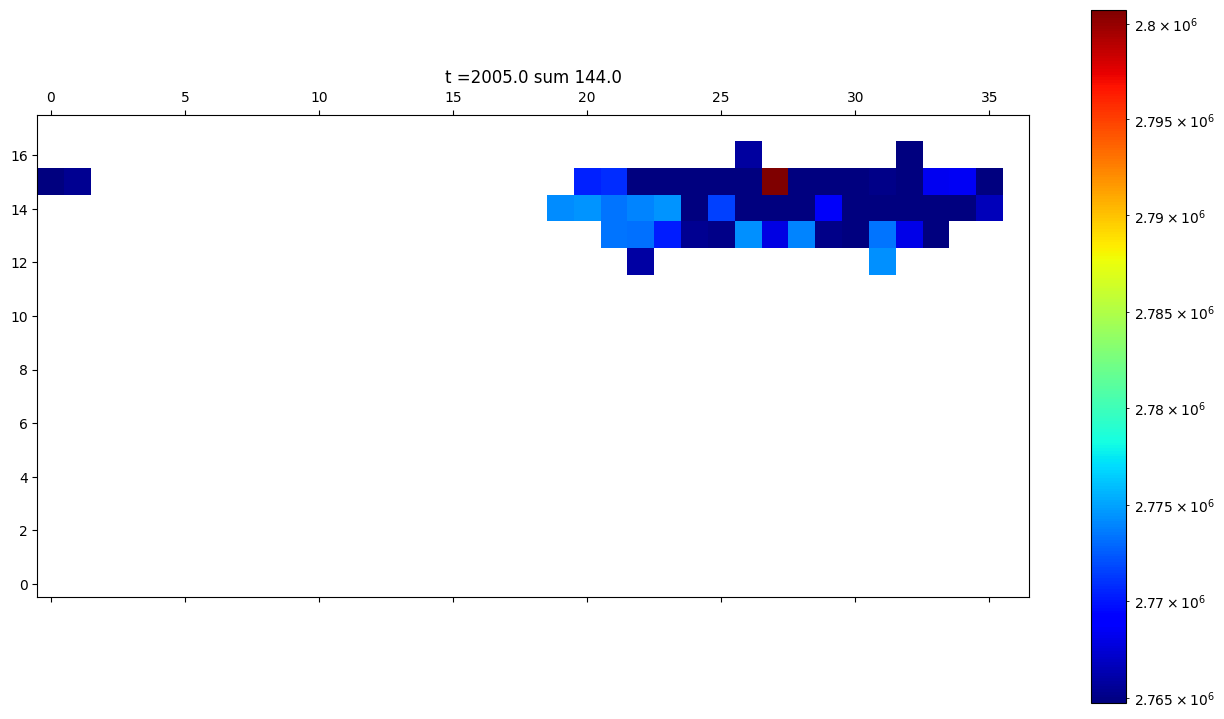

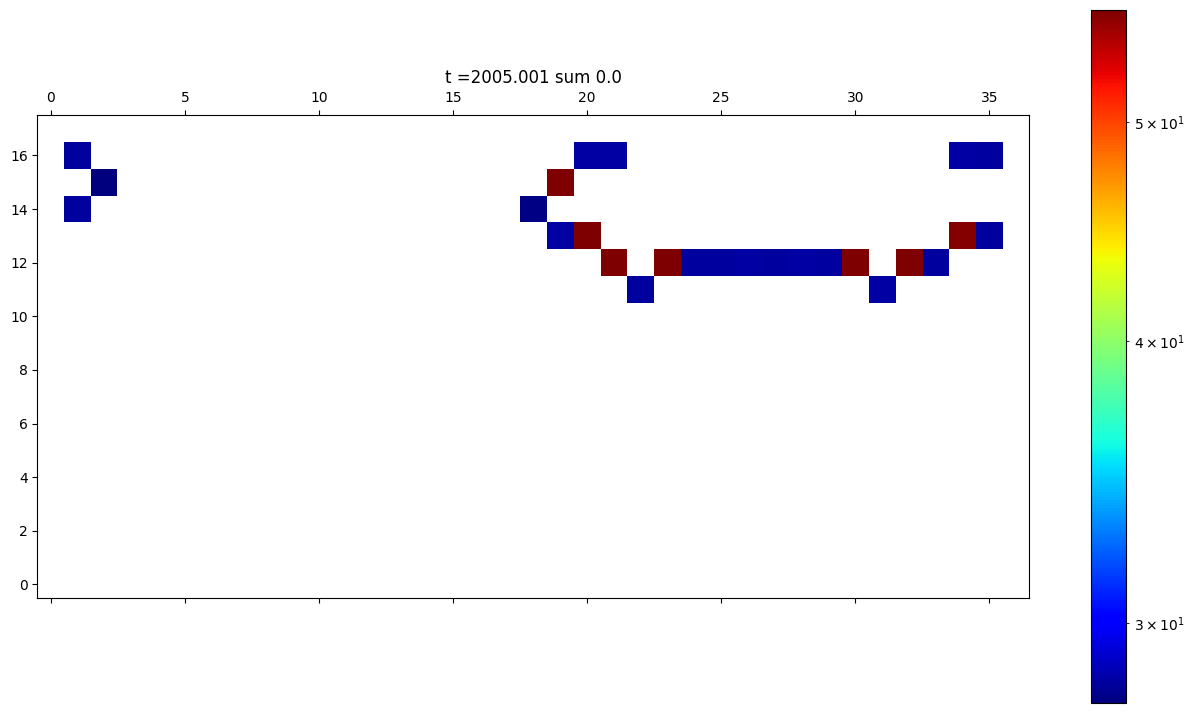

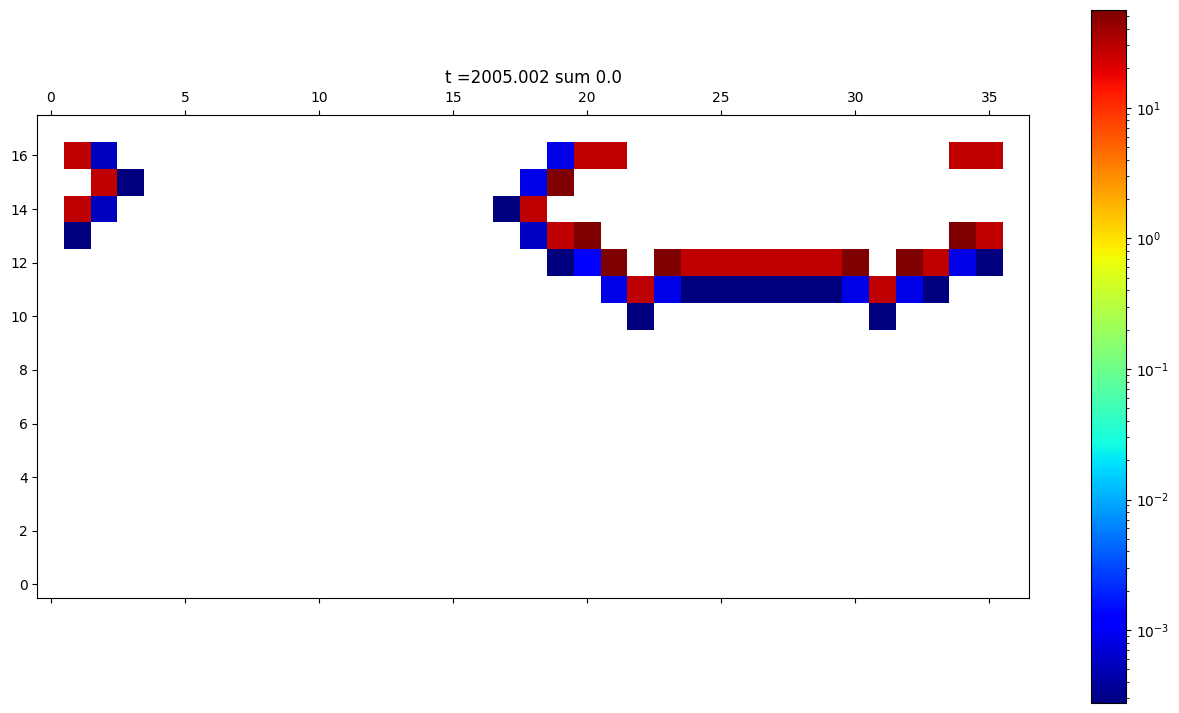

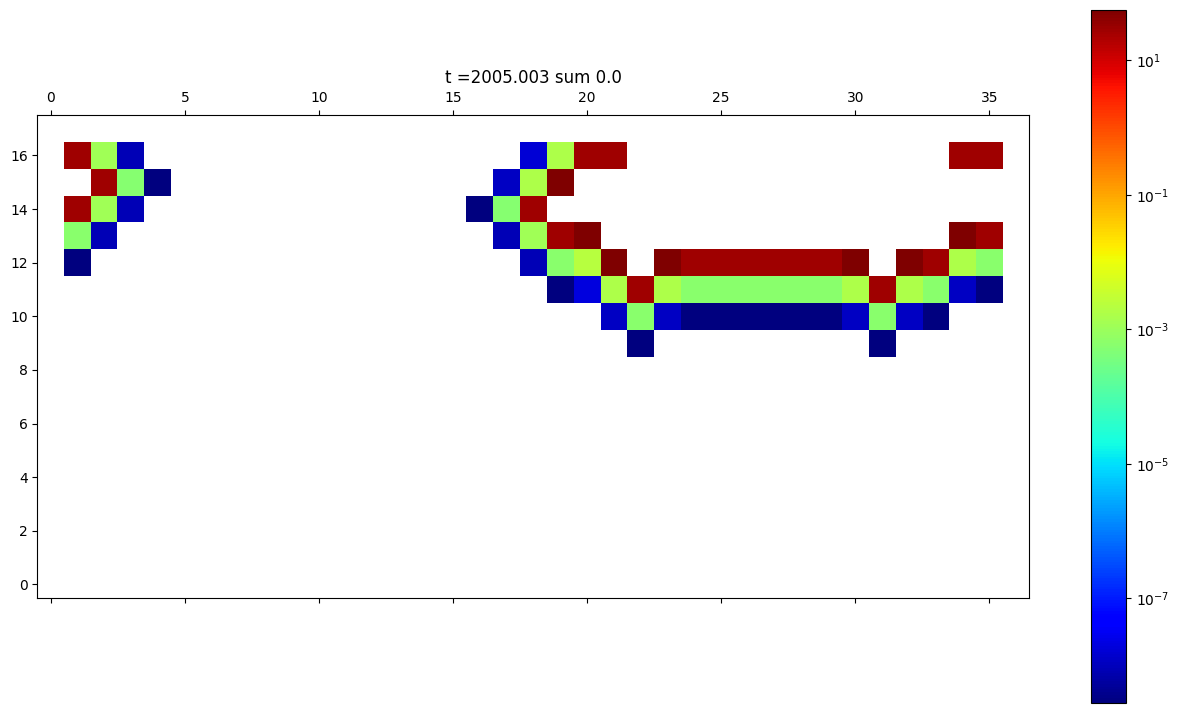

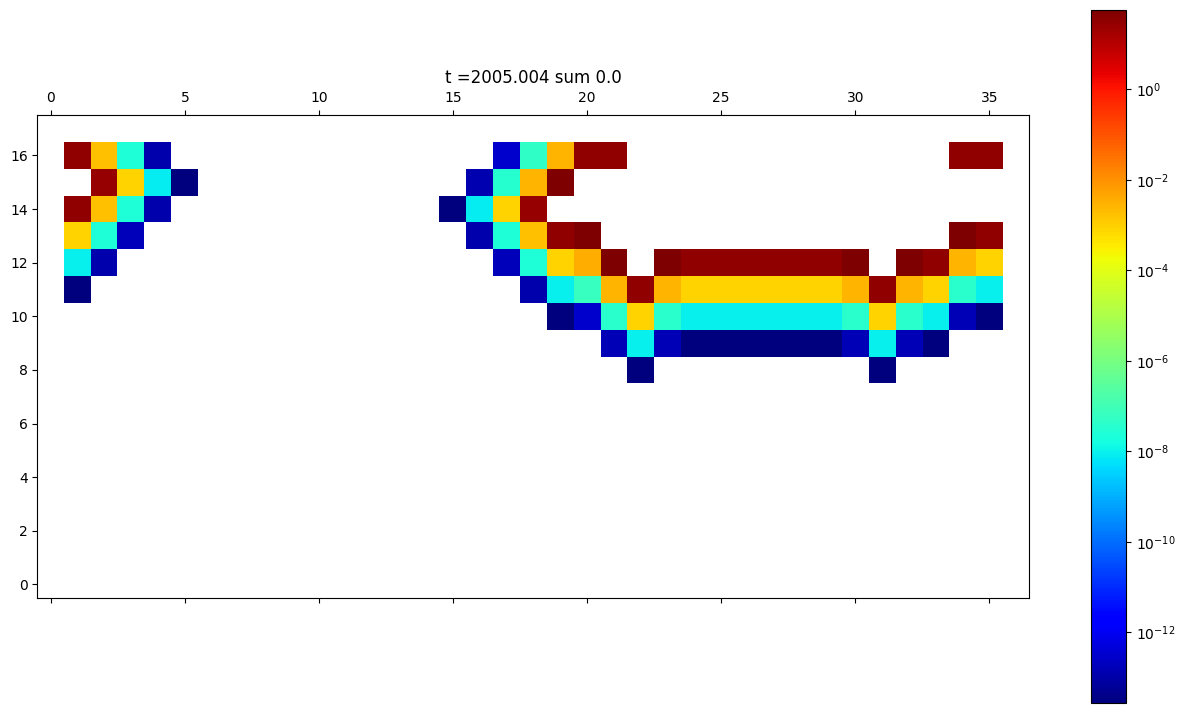

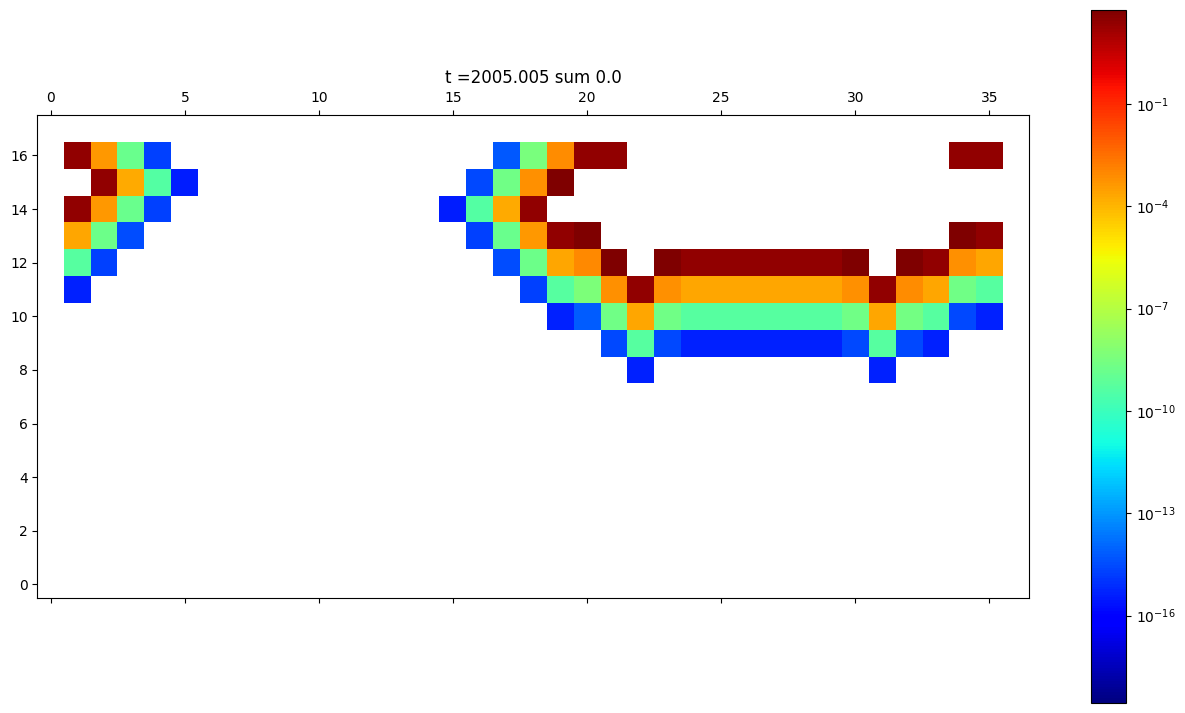

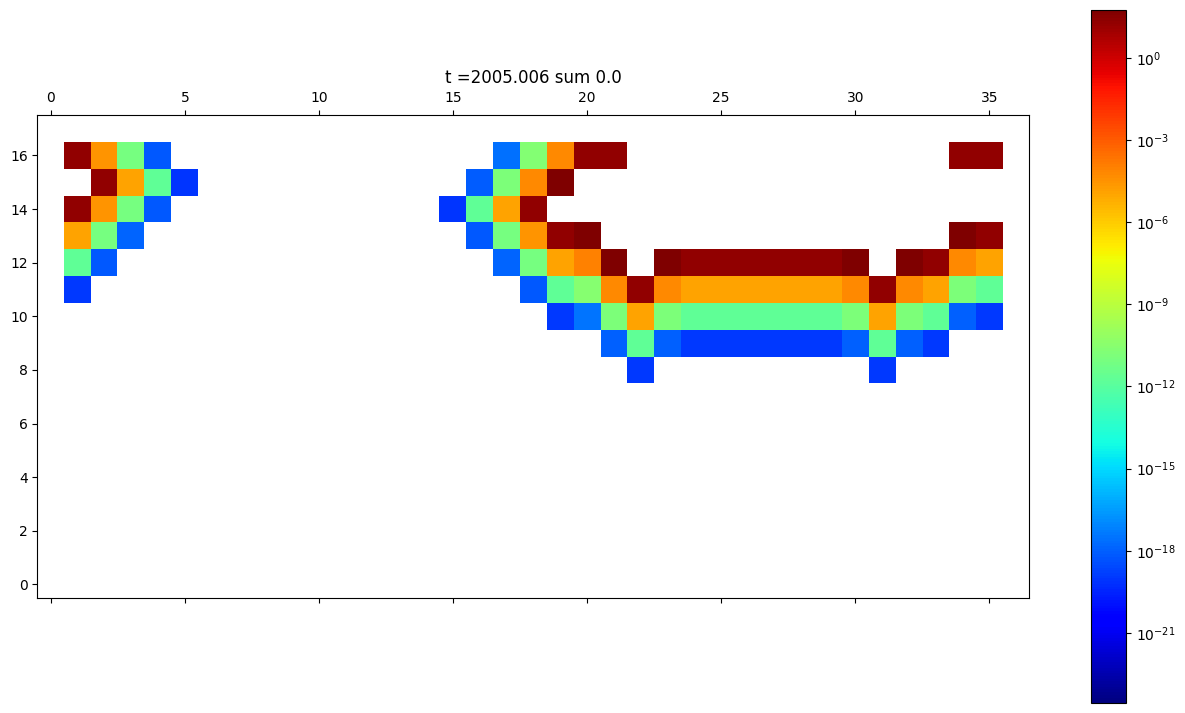

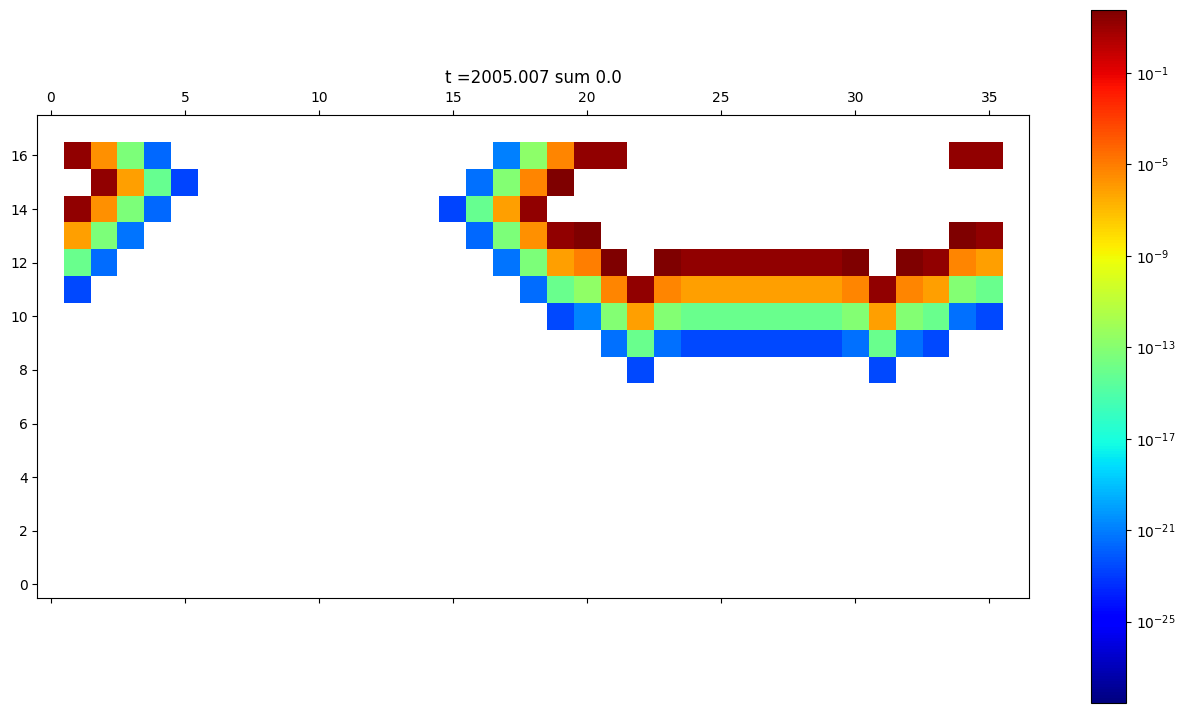

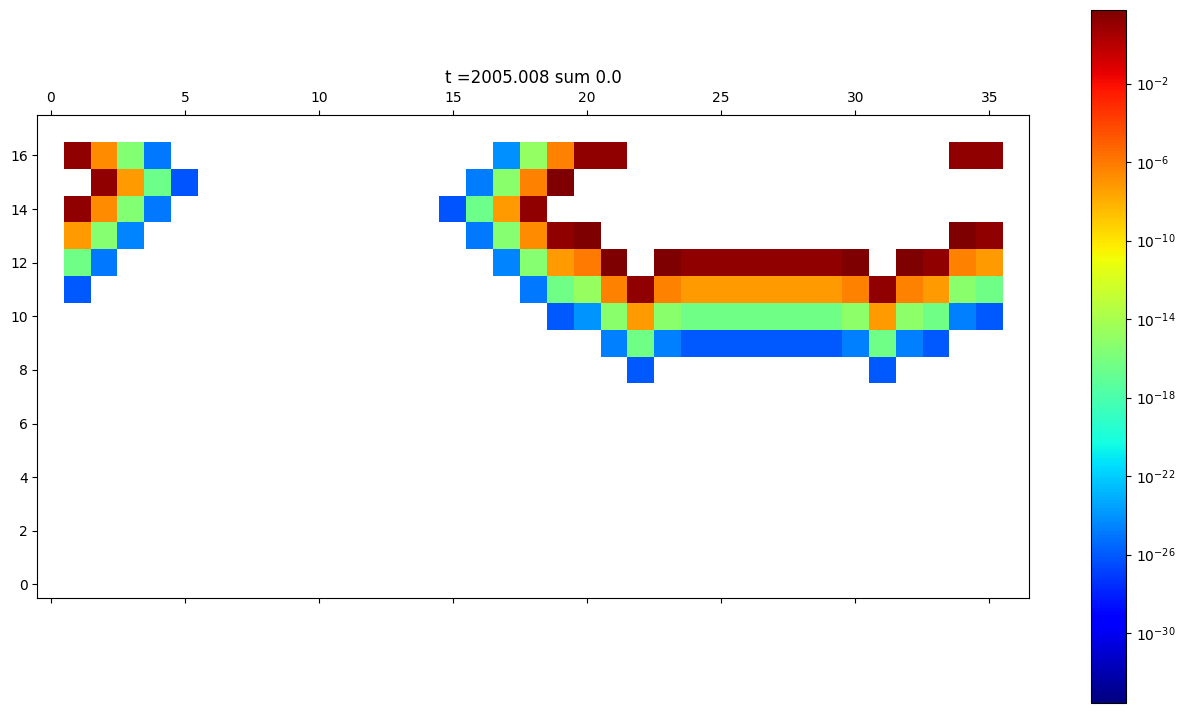

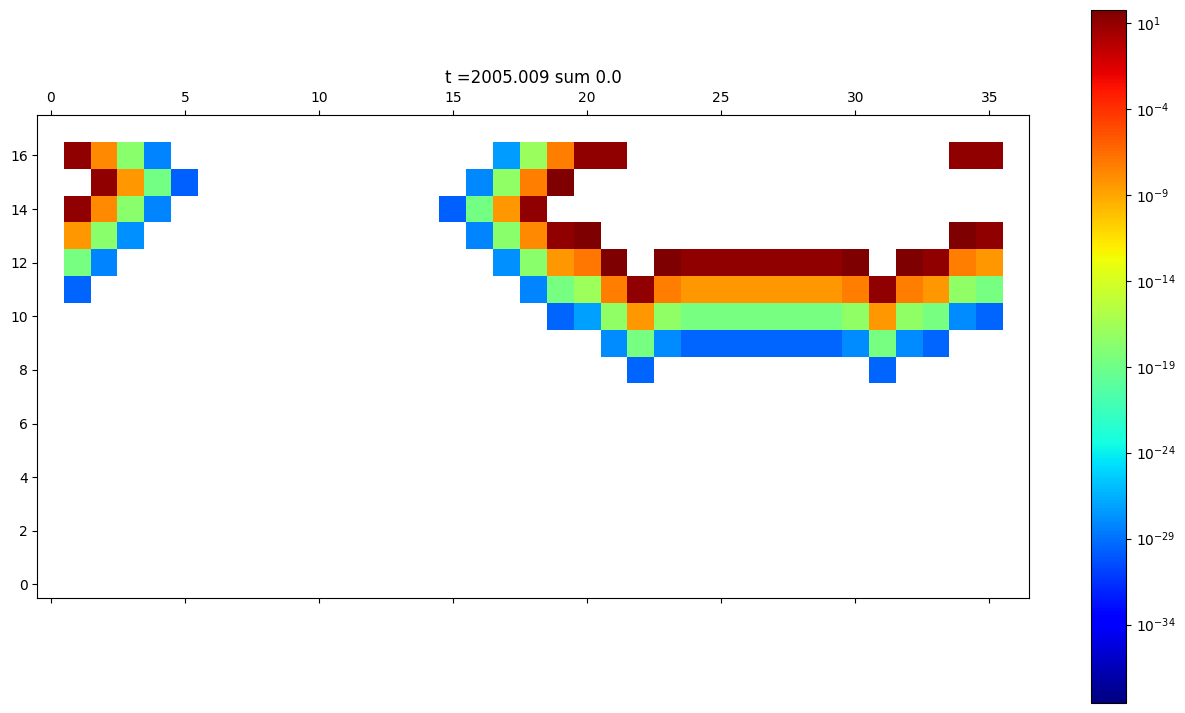

In [26]:
for i in tqdm(range(10)):
    ui = np.copy(u[i])
    ui[np.isnan(i)] = 0.0
    fig,ax = plt.subplots()
    fig.set_size_inches(16,9)
    cax = ax.matshow(ui.T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
    ax.invert_yaxis()
    fig.colorbar(cax)
    ax.set_title('t ={} sum {}'.format(tgrid[i],np.round(np.nansum(ui)/10**6,0)))